In [105]:
import mlflow
from mlflow.tracking import MlflowClient
import pandas as pd
import numpy as np
import seaborn as sns

In [106]:

import yaml
from pathlib import Path

sns.set_style("whitegrid")

# must match with training file train.py
mlflow.set_tracking_uri("http://localhost:" + "32769")
client: MlflowClient = MlflowClient()
experiment = client.get_experiment_by_name("CreditcardFraud_20Epochs_SmallerModel_v2")


all_runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
print(f"Found {len(all_runs)} runs")
#print(all_runs.columns)

Found 4 runs


In [107]:
#print(all_runs.columns)

In [108]:
print(all_runs.describe())
print(all_runs.columns)

       metrics.recall  metrics.precision  metrics.accuracy  metrics.f1_score  \
count        4.000000           4.000000          4.000000          4.000000   
mean         0.801020           0.779906          0.999100          0.772677   
std          0.058618           0.209998          0.000693          0.114121   
min          0.724490           0.467033          0.998069          0.607143   
25%          0.785714           0.766148          0.999017          0.743452   
50%          0.806122           0.866993          0.999394          0.812434   
75%          0.821429           0.880750          0.999478          0.841658   
max          0.867347           0.918605          0.999544          0.858696   

       metrics.train_loss  metrics.val_f1  metrics.val_loss  
count            4.000000        4.000000          4.000000  
mean             0.003687        0.809551          0.043992  
std              0.006533        0.168260          0.085727  
min              0.000014      

In [109]:
#Find best F1 Score model for dataset with noise 0.1 and imbalance_ratio 0.5 for each loss_fn also return the parameters for loss function aswell. Means alpha and gamma for focal and weight for wce
imbalance_ratios = all_runs['params.imbalance_ratio'].unique()

# Create results list
all_results = []

# Iterate through all combinations
for imbalance_ratio in imbalance_ratios:
    filtered_runs = all_runs[(all_runs['params.imbalance_ratio'] == imbalance_ratio)]

    if len(filtered_runs) == 0:
        continue

    # Group by loss function and find best F1 score for each
    best_models = filtered_runs.groupby('params.loss_function').apply(
        lambda group: group.loc[group['metrics.f1_score'].idxmax()]
    ).reset_index(drop=True)

    # Extract relevant information
    for idx, row in best_models.iterrows():
        loss_fn = row['params.loss_function']

        result = {
            'imbalance_ratio': imbalance_ratio,
            'loss_fn': loss_fn,
            'f1_score': row['metrics.f1_score'],
            'run_id': row['run_id']
        }

        # Extract loss-specific parameters
        if loss_fn == 'focal':
            result['alpha'] = row['params.alpha']
            result['gamma'] = row['params.gamma']
        elif loss_fn == 'wce':
            result['weight'] = row['params.ce_weight']

        # Add all metrics columns
        metrics_cols = [col for col in row.index if col.startswith('metrics.')]
        for metric_col in metrics_cols:
            metric_name = metric_col.replace('metrics.', '')
            result[metric_name] = row[metric_col]

        all_results.append(result)

results_df = pd.DataFrame(all_results)
print(results_df)

     imbalance_ratio loss_fn  f1_score                            run_id  \
0  577.8760162601626      ce  0.835979  4abaa3978c9d4f8987cf44318c98b05a   
1  577.8760162601626   focal  0.858696  17ef791c8c224a8b9ca6cdbefd7095e0   
2  577.8760162601626     wce  0.607143  f973467f00d74120bb7341fe3cf98eb4   

     recall  precision  accuracy  train_loss    val_f1  val_loss alpha gamma  \
0  0.806122   0.868132  0.999456    0.001170  0.914894  0.003034   NaN   NaN   
1  0.806122   0.918605  0.999544    0.000109  0.891304  0.000239  0.25   2.0   
2  0.867347   0.467033  0.998069    0.013454  0.558442  0.172567   NaN   NaN   

  weight  
0    NaN  
1    NaN  
2    100  


C:\Users\CYann\AppData\Local\Temp\ipykernel_25324\139383030.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_models = filtered_runs.groupby('params.loss_function').apply(


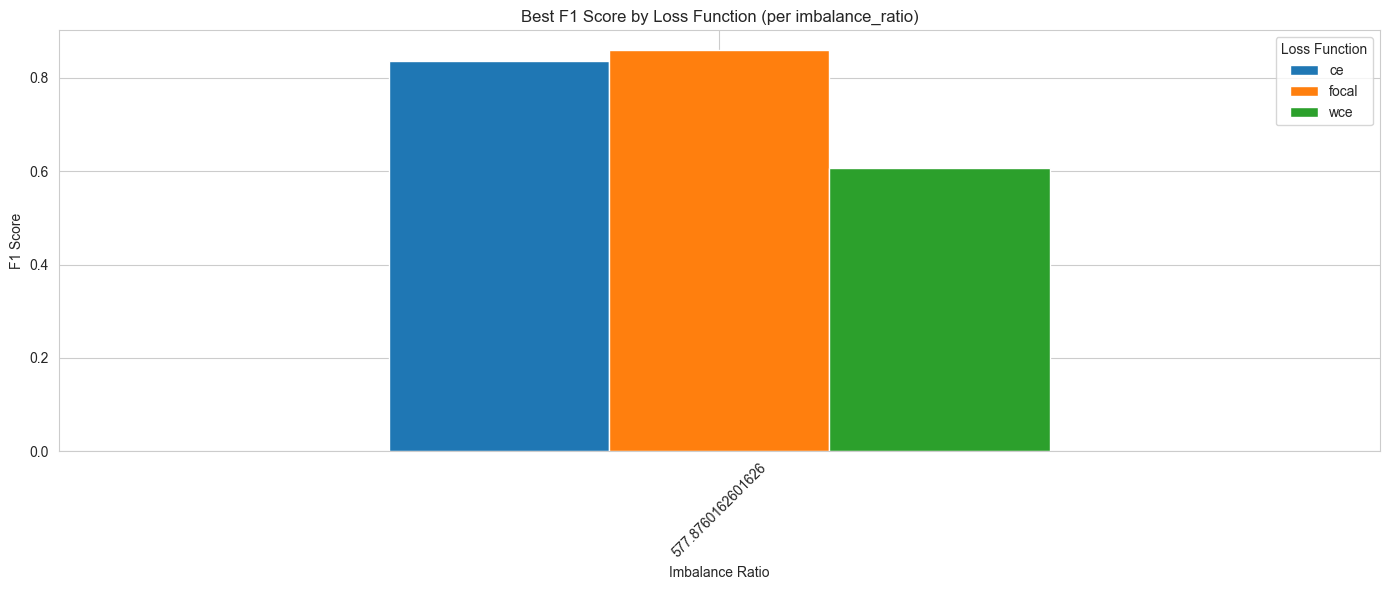

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# 1. F1 Score comparison across loss functions for each imbalance_ratio
fig, ax = plt.subplots(figsize=(14, 6))
pivot_f1 = results_df.pivot_table(
    values='f1_score',
    index='imbalance_ratio',
    columns='loss_fn',
    aggfunc='first'
)
pivot_f1.plot(kind='bar', ax=ax)
ax.set_title('Best F1 Score by Loss Function (per imbalance_ratio)')
ax.set_xlabel('Imbalance Ratio')
ax.set_ylabel('F1 Score')
ax.legend(title='Loss Function')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

In [111]:
def get_best_runs_per_config(all_runs: pd.DataFrame, num_layers: int) -> pd.DataFrame:
    """
    Extract the best runs per configuration (imbalance_ratio + loss_function)
    filtered by number of layers.
    """
    df = all_runs.copy()

    # Filter by number of layers (small or big model)
    df = df[df['params.num_layers'].astype(int) == num_layers]

    # Extract relevant columns
    df['imbalance_ratio'] = df['params.imbalance_ratio'].astype(float)
    df['loss_function'] = df['params.loss_function']

    # Group by imbalance ratio and loss function
    group_cols = ['imbalance_ratio', 'loss_function']

    # Get index of best val_f1 per group
    best_idx = df.groupby(group_cols)['metrics.val_f1'].idxmax()
    best = df.loc[best_idx].reset_index(drop=True)

    return best

# Usage
best_small = get_best_runs_per_config(all_runs, num_layers=2)
best_big   = get_best_runs_per_config(all_runs, num_layers=4)

# Display relevant columns
display(best_small[['run_id', 'imbalance_ratio', 'loss_function', 'metrics.val_f1']])
display(best_big[['run_id', 'imbalance_ratio', 'loss_function', 'metrics.val_f1']])


,run_id,imbalance_ratio,loss_function,metrics.val_f1
0,4abaa3978c9d4f8987cf44318c98b05a,577.876016,ce,0.914894
1,17ef791c8c224a8b9ca6cdbefd7095e0,577.876016,focal,0.891304
2,f973467f00d74120bb7341fe3cf98eb4,577.876016,wce,0.558442


,run_id,imbalance_ratio,loss_function,metrics.val_f1


In [112]:
client = MlflowClient()

def fetch_val_f1_history(best_df: pd.DataFrame, num_layer: int) -> pd.DataFrame:
    rows = []

    for _, row in best_df.iterrows():
        run_id = row['run_id']
        hist = client.get_metric_history(run_id, "val_f1")

        for m in hist:
            rows.append({
                "step": m.step,
                "val_f1": m.value,
                "imbalance_ratio": float(row['imbalance_ratio']),
                "loss_function": row['loss_function'],
                "num_layer": num_layer,
            })

    return pd.DataFrame(rows)

hist_small = fetch_val_f1_history(best_small, 2)
hist_big   = fetch_val_f1_history(best_big, 4)


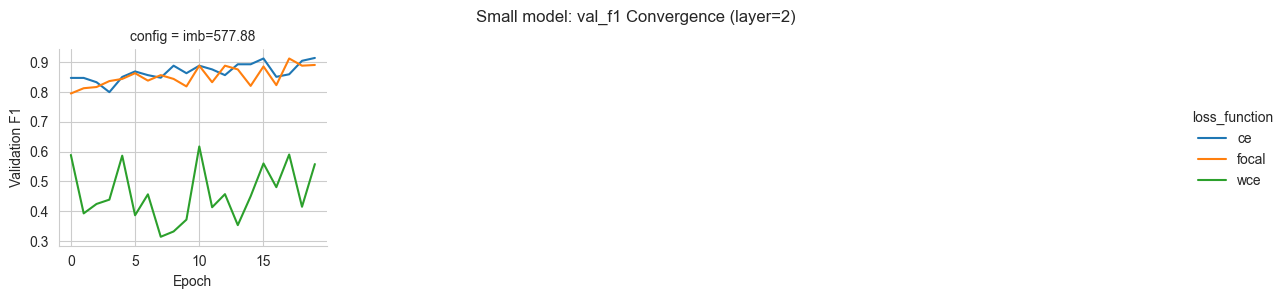

No history found for 4 layers


In [113]:
def plot_convergence_grid(hist_df: pd.DataFrame, num_layer: int, title_prefix: str):
    if hist_df.empty:
        print(f"No history found for {num_layer} layers")
        return

    df = hist_df.copy()
    # Use imbalance ratio only for config labeling
    df['config'] = df.apply(lambda r: f"imb={r['imbalance_ratio']:.2f}", axis=1)

    g = sns.relplot(
        data=df,
        x="step",
        y="val_f1",
        hue="loss_function",
        kind="line",
        col="config",
        col_wrap=4,
        height=3,
        facet_kws={"sharex": True, "sharey": True},
    )
    g.set_axis_labels("Epoch", "Validation F1")
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f"{title_prefix}: val_f1 Convergence (layer={num_layer})")
    plt.show()

# Example usage
plot_convergence_grid(hist_small, 2, "Small model")
plot_convergence_grid(hist_big, 4, "Big model")

In [114]:
losses = ["ce", "wce", "focal"]  # desired order for coloring

def plot_best_loss_heatmap(best_df: pd.DataFrame, num_layer: int, title_prefix: str):
    df = best_df.copy()
    df['imbalance_ratio'] = df['imbalance_ratio'].astype(float)

    # Use a dummy index since we only have imbalance_ratio
    df['dummy_index'] = 0

    # --------------------------------------------------
    # Collect best loss(es) per imbalance_ratio
    # --------------------------------------------------
    grouped = df.groupby('imbalance_ratio')
    rows = []

    for imb, g in grouped:
        max_val = g['metrics.val_f1'].max()
        best_rows = g[g['metrics.val_f1'] == max_val]

        labels = []
        base_loss_indices = []

        for _, r in best_rows.iterrows():
            loss_fn = r['loss_function']

            if loss_fn in losses:
                base_loss_indices.append(losses.index(loss_fn))

            # Build label with hyperparams when relevant
            if loss_fn == "wce":
                ce_w = r.get('params.ce_weight', None)
                label = f"wce(w={ce_w})" if ce_w is not None else "wce"
            elif loss_fn == "focal":
                alpha = r.get('params.alpha', None)
                gamma = r.get('params.gamma', None)
                if alpha is not None and gamma is not None:
                    label = f"focal(a={alpha}, g={gamma})"
                else:
                    label = "focal"
            else:
                label = loss_fn

            labels.append(label)

        annot = "\n".join(labels)
        mean_code = np.mean(base_loss_indices) if base_loss_indices else 0.0

        rows.append({
            "dummy_index": 0,
            "imbalance_ratio": imb,
            "annot": annot,
            "loss_code": mean_code
        })

    df_best = pd.DataFrame(rows)

    # Pivot using the dummy index
    table = df_best.pivot(index='dummy_index', columns='imbalance_ratio', values='loss_code')
    annot_table = df_best.pivot(index='dummy_index', columns='imbalance_ratio', values='annot')

    # --------------------------------------------------
    # Plot
    # --------------------------------------------------
    plt.figure(figsize=(8, 2))  # shorter height since only one row
    ax = sns.heatmap(
        table,
        annot=annot_table,
        fmt="",
        cmap='viridis',
        linewidths=0.5,
        cbar=False
    )

    ax.set_title(f"{title_prefix}: Best Loss per Imbalance Ratio — {num_layer} layers\n(Ties shown, hyperparams for WCE/Focal)")
    ax.set_xlabel("imbalance_ratio")
    ax.set_ylabel("")

    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
